<a href="https://colab.research.google.com/github/stellaevat/ontology-mapping/blob/main/colabs/faiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 5.9 MB/s eta 0:00:00


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

In [9]:
import gc
import itertools
import json
import torch
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Read/Write to file

In [10]:
def read_bi_embeddings_from_file(filepath):
  indices, sources, targets = [], [], []

  with open(filepath) as f:
    for line in tqdm(f):
      strings = line.strip().split(",[")
      lists = [list(map(float, s.strip("[]").split(","))) for s in strings[1:]]
      source, target = lists
      index = int(strings[0])

      indices.append(index)
      sources.append(source)
      targets.append(target)

  bi_embeddings = {"indices" : indices,
                   "sources" : np.array(sources, dtype=np.single),
                   "targets" : np.array(targets, dtype=np.single)}
  return bi_embeddings

def read_onto_embeddings_from_file(filepath):
  indices, embeddings = [], None

  with open(filepath) as f:
    for line in tqdm(f):
      strings = line.strip().split(",[")
      embedding = np.array(list(map(float, strings[1].strip("[]").split(","))), dtype=np.single).reshape(1,-1)
      index = int(strings[0])

      indices.append(index)
      embeddings = embedding if embeddings is None else np.concatenate((embeddings, embedding), axis=0, dtype=np.single)

  onto_embeddings = {"indices"    : indices,
                     "embeddings" : embeddings}
  return onto_embeddings

# Faiss ranking

In [ ]:
def get_real_ranks(I, bi_embeddings, db_embeddings):
  ranks = []
  for i, target_embed in tqdm(enumerate(bi_embeddings["targets"])):
    for rank, j in enumerate(I[i]):
      ranked_embed = db_embeddings[j]
      if np.array_equal(target_embed, ranked_embed):
        ranks.append(rank + 1)
        break
  return ranks

def plot_ranks(ranks, feature, negatives, database):
  plt.figure()
  plt.hist(ranks, bins=max(ranks) // 100)
  plt.xlabel("Subsumer rank")
  plt.ylabel("No. of queries")
  plt.title(f"Correct subsumer rank distribution across queries ({feature}, {negatives}, {database})")
  plt.savefig(f"bi_ranking_histogram_{feature}_{negatives}_{database}.png")

def compute_result(ranks):
  result = {}

  raw_at_rank = lambda x: len([r for r in ranks if r <= x])
  hits_at_rank = lambda x: x / len(ranks)
  for r in [1, 5, 10, 100, 1000]:
    score = hits_at_rank(raw_at_rank(r))
    result[f"H@{r}"] = score

  result["MRR"]     = np.mean(1 / np.array(ranks))
  result["Highest"] = np.min(ranks)
  result["Median"]  = np.median(ranks)
  result["Mean"]    = np.mean(ranks)
  result["Lowest"]  = np.max(ranks)

  return result

def pretty_print_result(result, feature, negatives, database):
  result_str = f"\nPerformance on ({feature}, {negatives}, {database}):\n\n"

  for (name, value) in result.items():
    if name.startswith("H@"):
      result_str += f"{name:<6} = {value:.3f}\n"
    elif name == "MRR":
      result_str += f"MRR    = {value:.3f}\n\n"
    elif not isinstance(value, str):
      result_str += f"{name}:" + " " * (13 - len(name)) + f"{value:.1f}\n"

  result_str += "\n"
  print(result_str)

1284it [00:02, 545.69it/s]
2391it [00:03, 653.89it/s]
2361it [00:03, 635.34it/s]
13374it [01:49, 122.28it/s]



term random hard
Database (hard) contains 3645 terms


1284it [00:00, 1413.69it/s]


1284


term random onto
Database (onto) contains 14658 terms


1284it [00:06, 190.15it/s]


1284


term random random
Database (random) contains 3675 terms


1284it [00:00, 1486.66it/s]


1284



652it [00:01, 355.69it/s]
1922it [00:02, 704.39it/s] 
2203it [00:02, 788.72it/s]
13358it [01:44, 128.44it/s]



term multi hard
Database (hard) contains 2855 terms


652it [00:00, 1419.31it/s]


652


term multi onto
Database (onto) contains 14010 terms


652it [00:01, 362.97it/s]


652


term multi random
Database (random) contains 2574 terms


652it [00:00, 2587.45it/s]


652



643it [00:01, 347.41it/s]
2253it [00:02, 781.62it/s]
1891it [00:02, 683.73it/s]
13366it [01:50, 120.98it/s]



term neighbour hard
Database (hard) contains 2534 terms


643it [00:02, 245.32it/s]


643


term neighbour onto
Database (onto) contains 14009 terms


643it [00:03, 165.37it/s]


643


term neighbour random
Database (random) contains 2896 terms


643it [00:03, 170.10it/s]


643



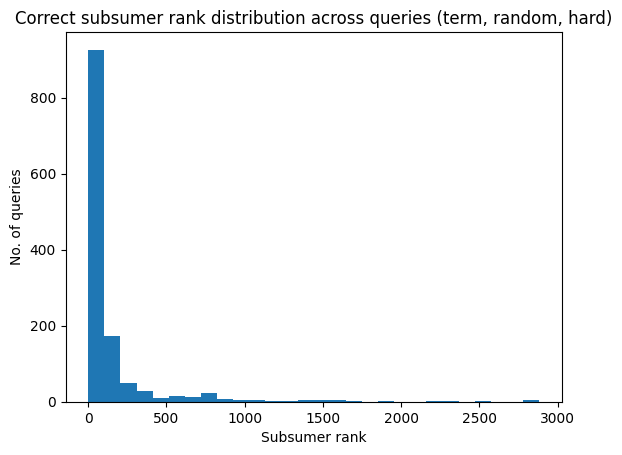

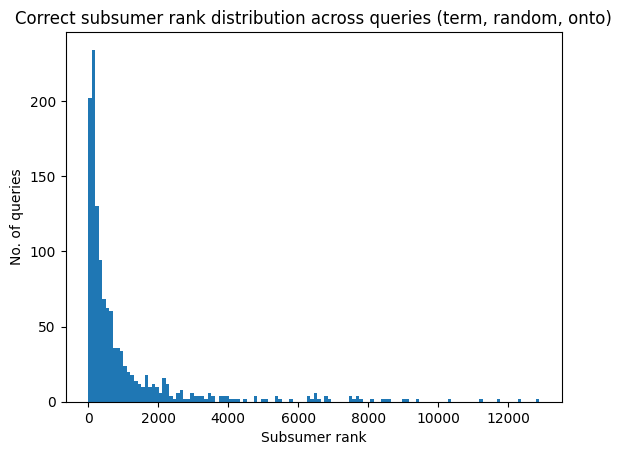

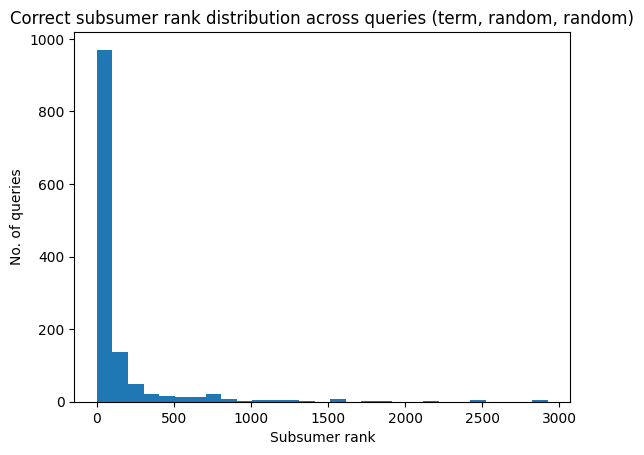

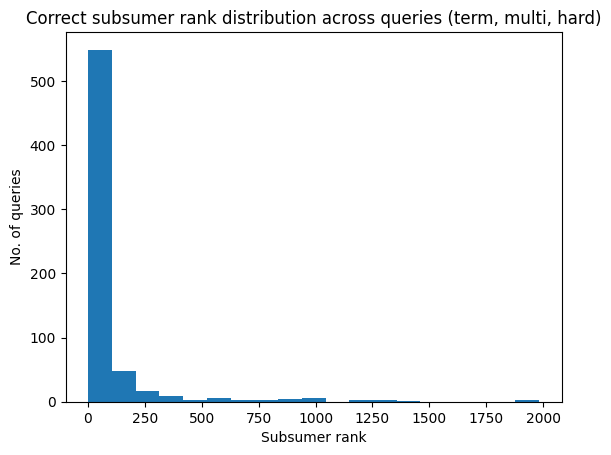

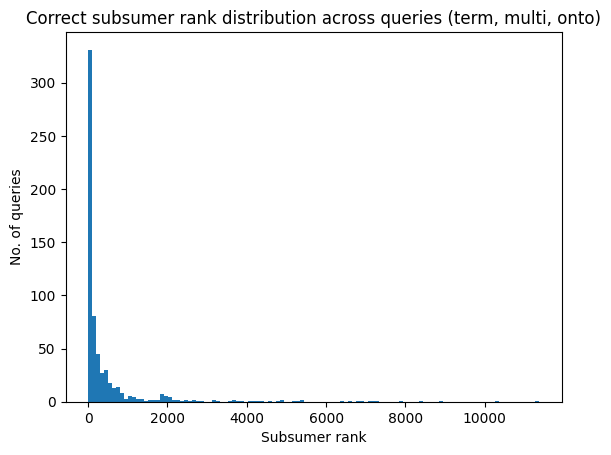

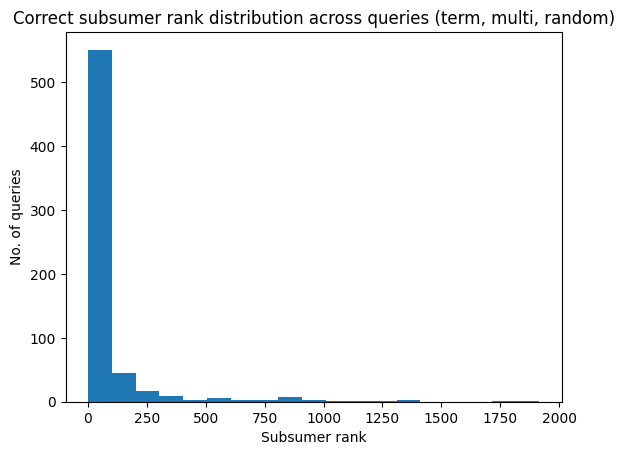

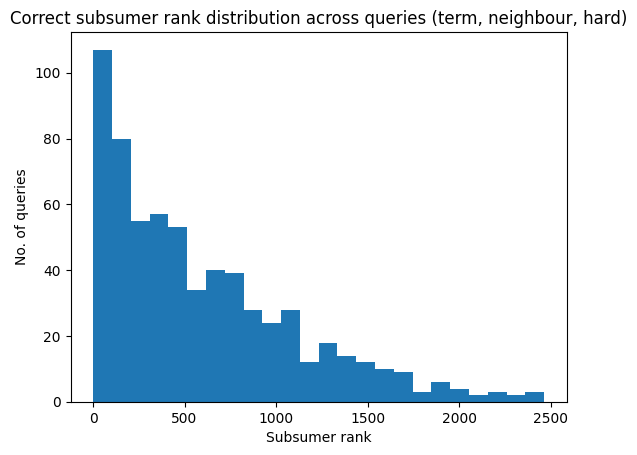

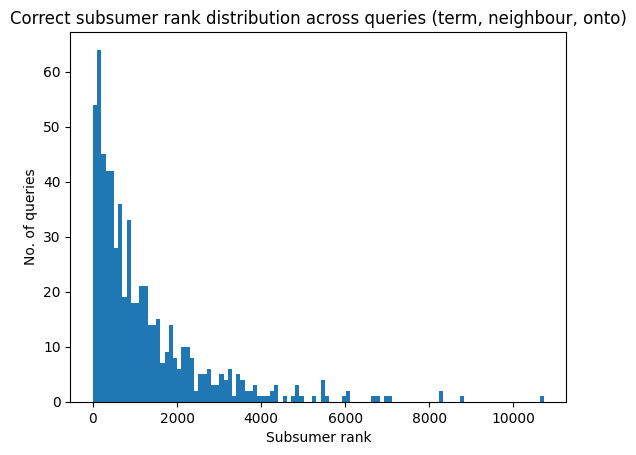

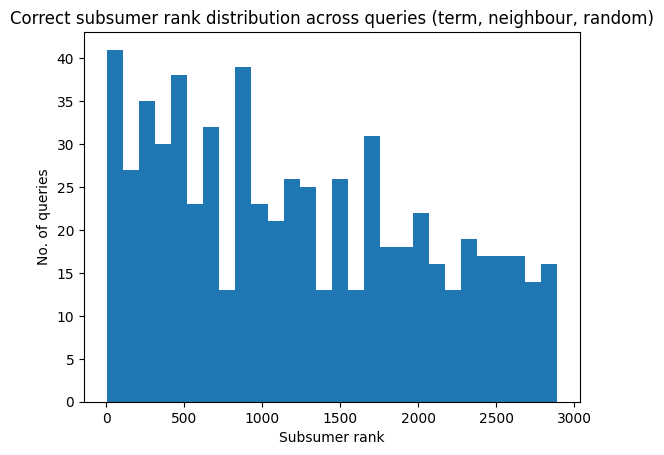

In [ ]:
dir = ""
dir = "/content/drive/MyDrive/embeddings/"
features = ['term', 'int', 'ext']
negative_sampling = ['random', 'multi', 'neighbour']
columns = ["database", "feature", "negatives", "H@1", "H@5", "H@10", "H@50", "H@100", "H@1000", "MRR", "Highest", "Median", "Mean", "Lowest"]
# results_df = pd.DataFrame(columns=columns)
# all_ranks = {}

for (feature, negatives) in list(itertools.product(features, negative_sampling))[:3]:
  bi_embeddings = read_bi_embeddings_from_file(f"{dir}bi_test_embeddings_{feature}_{negatives}.csv")
  random_embeddings = read_onto_embeddings_from_file(f"{dir}random_embeddings_{feature}_{negatives}.csv")
  hard_embeddings = read_onto_embeddings_from_file(f"{dir}hard_embeddings_{feature}_{negatives}.csv")
  onto_embeddings = read_onto_embeddings_from_file(f"{dir}doid_embeddings_{feature}_{negatives}.csv")
  databases = {"hard" : hard_embeddings, "onto" : onto_embeddings, "random" : random_embeddings}

  for (db_type, db_embeddings) in databases.items():
    if db_embeddings is None:
      continue

    print()
    print(feature, negatives, db_type)

    xq = bi_embeddings["sources"]
    xb = db_embeddings["embeddings"]

    xb = np.concatenate((xb, bi_embeddings["targets"]), axis=0)
    print(f"Database ({db_type}) contains {len(xb)} terms")

    d = xb[0].shape[0]
    q_size = len(xq)
    db_size = len(xb)

    res = faiss.StandardGpuResources()
    index_flat = faiss.IndexFlatIP(d)
    index_flat.add(xb)
    D, I = index_flat.search(xq, db_size)

    ranks = get_real_ranks(I, bi_embeddings, xb)
    if not ranks:
      print("No ranks!\n")
      continue
    else:
      print(len(ranks))

    plot_ranks(ranks, feature, negatives, db_type)
    result = {"database" : db_type, "feature" : feature, "negatives" : negatives}
    result = result | compute_result(ranks)
    # pretty_print_result(result, feature, negatives, db_type)

    results_df.loc[len(results_df)] = result
    results_df.sort_values(by=["database", "feature", "negatives"]).to_csv("bi_ranking_metrics.csv", index=False)

    all_ranks[(db_type, feature, negatives)] = ranks
    with open("bi_ranks.csv", "a") as f:
      f.write(f"{db_type},{feature},{negatives},{','.join(list(map(str, ranks)))}\n")

    print()

In [ ]:
json_ranks = {",".join(k) : v for (k,v) in all_ranks.items()}
with open('ranks.json', 'w', encoding='utf-8') as f:
    json.dump(json_ranks, f, ensure_ascii=False, indent=4)

# Search space pruning

In [3]:
def read_bi_sentences(filepath):
  source_sentences, target_sentences, labels = [], [], []
  with open(filepath) as f:
    for line in f:
      source_sentence, target_sentence, label = [field.strip('"') for field in line.strip().split('","')]
      source_sentences.append(source_sentence)
      target_sentences.append(target_sentence)
      labels.append(label)
  return source_sentences, target_sentences, labels

def read_onto_sentences(filepath):
  sentences = []
  with open(filepath) as f:
    for line in f:
      sentences.append(line.strip().strip('"'))
  return sentences

def write_cross_encoder_sentences(sentences, filepath):
  sentences, labels = sentences
  with open(filepath, "w") as f:
    for (sentence, label) in zip(sentences, labels):
      f.write(f'"{sentence}","{label}"\n')

In [21]:
dir = "/content/drive/MyDrive"
feature, negatives, db_type = 'ext', 'multi', "onto"
direction = "ncit2doid"
print(feature, negatives, db_type)

bi_embeddings = read_bi_embeddings_from_file(f"{dir}/embeddings/bi_test_embeddings_{feature}_{negatives}.csv")
db_embeddings = read_onto_embeddings_from_file(f"{dir}/embeddings/doid_embeddings_{feature}_{negatives}.csv")

ext multi onto


652it [00:00, 1205.73it/s]
13673it [01:41, 134.59it/s]


In [22]:
xq = bi_embeddings["sources"]
xb = db_embeddings["embeddings"]
xb = np.concatenate((xb, bi_embeddings["targets"]), axis=0)


offset = len(db_embeddings["embeddings"])
index = {i : f"o{db_embeddings['indices'][i]}" for i in range(offset)}
for i in range(len(xq)):
  index[offset + i] = f"t{bi_embeddings['indices'][i]}"

d = xb[0].shape[0]
q_size = len(xq)
db_size = len(xb)

res = faiss.StandardGpuResources()
index_flat = faiss.IndexFlatIP(d)
index_flat.add(xb)
D, I = index_flat.search(xq, db_size)

In [24]:
sentence_feature = "int"
source_sentences, target_sentences, labels = read_bi_sentences(f"{dir}/sentences/bi_sentences_{sentence_feature}_{negatives}_{direction}.csv")
onto_sentences = read_onto_sentences(f"{dir}/sentences/{direction.split('2')[1]}_sentences_{sentence_feature}.csv")
sentences, labels = [], []
cutoff = 100

for i in range(len(xq)):
  for j in I[i][:cutoff]:
    label = 0

    source_index = bi_embeddings["indices"][i]
    source_sentence = source_sentences[source_index]

    target_code, target_index = index[j][0], int(index[j][1:])
    if target_code == "t":
      target_sentence = target_sentences[target_index]
      if source_index == target_index:
        label = 1
    else:
      target_sentence = onto_sentences[target_index]


    sentence = "[SEP][CLS]".join([source_sentence, target_sentence])
    sentences.append(sentence)
    labels.append(label)

write_cross_encoder_sentences((sentences, labels), f"faiss_{cutoff}_sentences_{sentence_feature}_{direction}.csv")